<a href="https://colab.research.google.com/github/IlyaKo4atkov/My-machine-learning-projects/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Условие задачи

## Используя датасет котировок Apple, разработал модель нейронной сети, которая делает прогнозирование котировок. Использовал дифференцирование датасета для устранения тренда.

### Импорт необходимых библиотек

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from keras.layers import MaxPooling1D, RepeatVector
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

### Загрузка данных

In [ ]:
# импорт файла с данными о котировках акций Apple
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

# Загрузка только необходимых колонок usecols, укажем, что колонку Date необходимо преобразовать в формат DateTime (parse_dates) и сделать индексом index_col
price = pd.read_csv("./AAPL.csv", index_col='Date', usecols = ['Adj Close', 'Volume', 'Date'], parse_dates=['Date'])

price.head()

--2024-10-27 10:59:33--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv’

AAPL.csv            100%[===================>] 182.17K   354KB/s    in 0.5s    

2024-10-27 10:59:34 (354 KB/s) - ‘AAPL.csv’ saved [186539/186539]



,Adj Close,Volume
Date,,
2014-01-02,17.296652,234684800
2014-01-03,16.916719,392467600
2014-01-06,17.008968,412610800
2014-01-07,16.887323,317209200
2014-01-08,16.994270,258529600


### Визуализация временного ряда

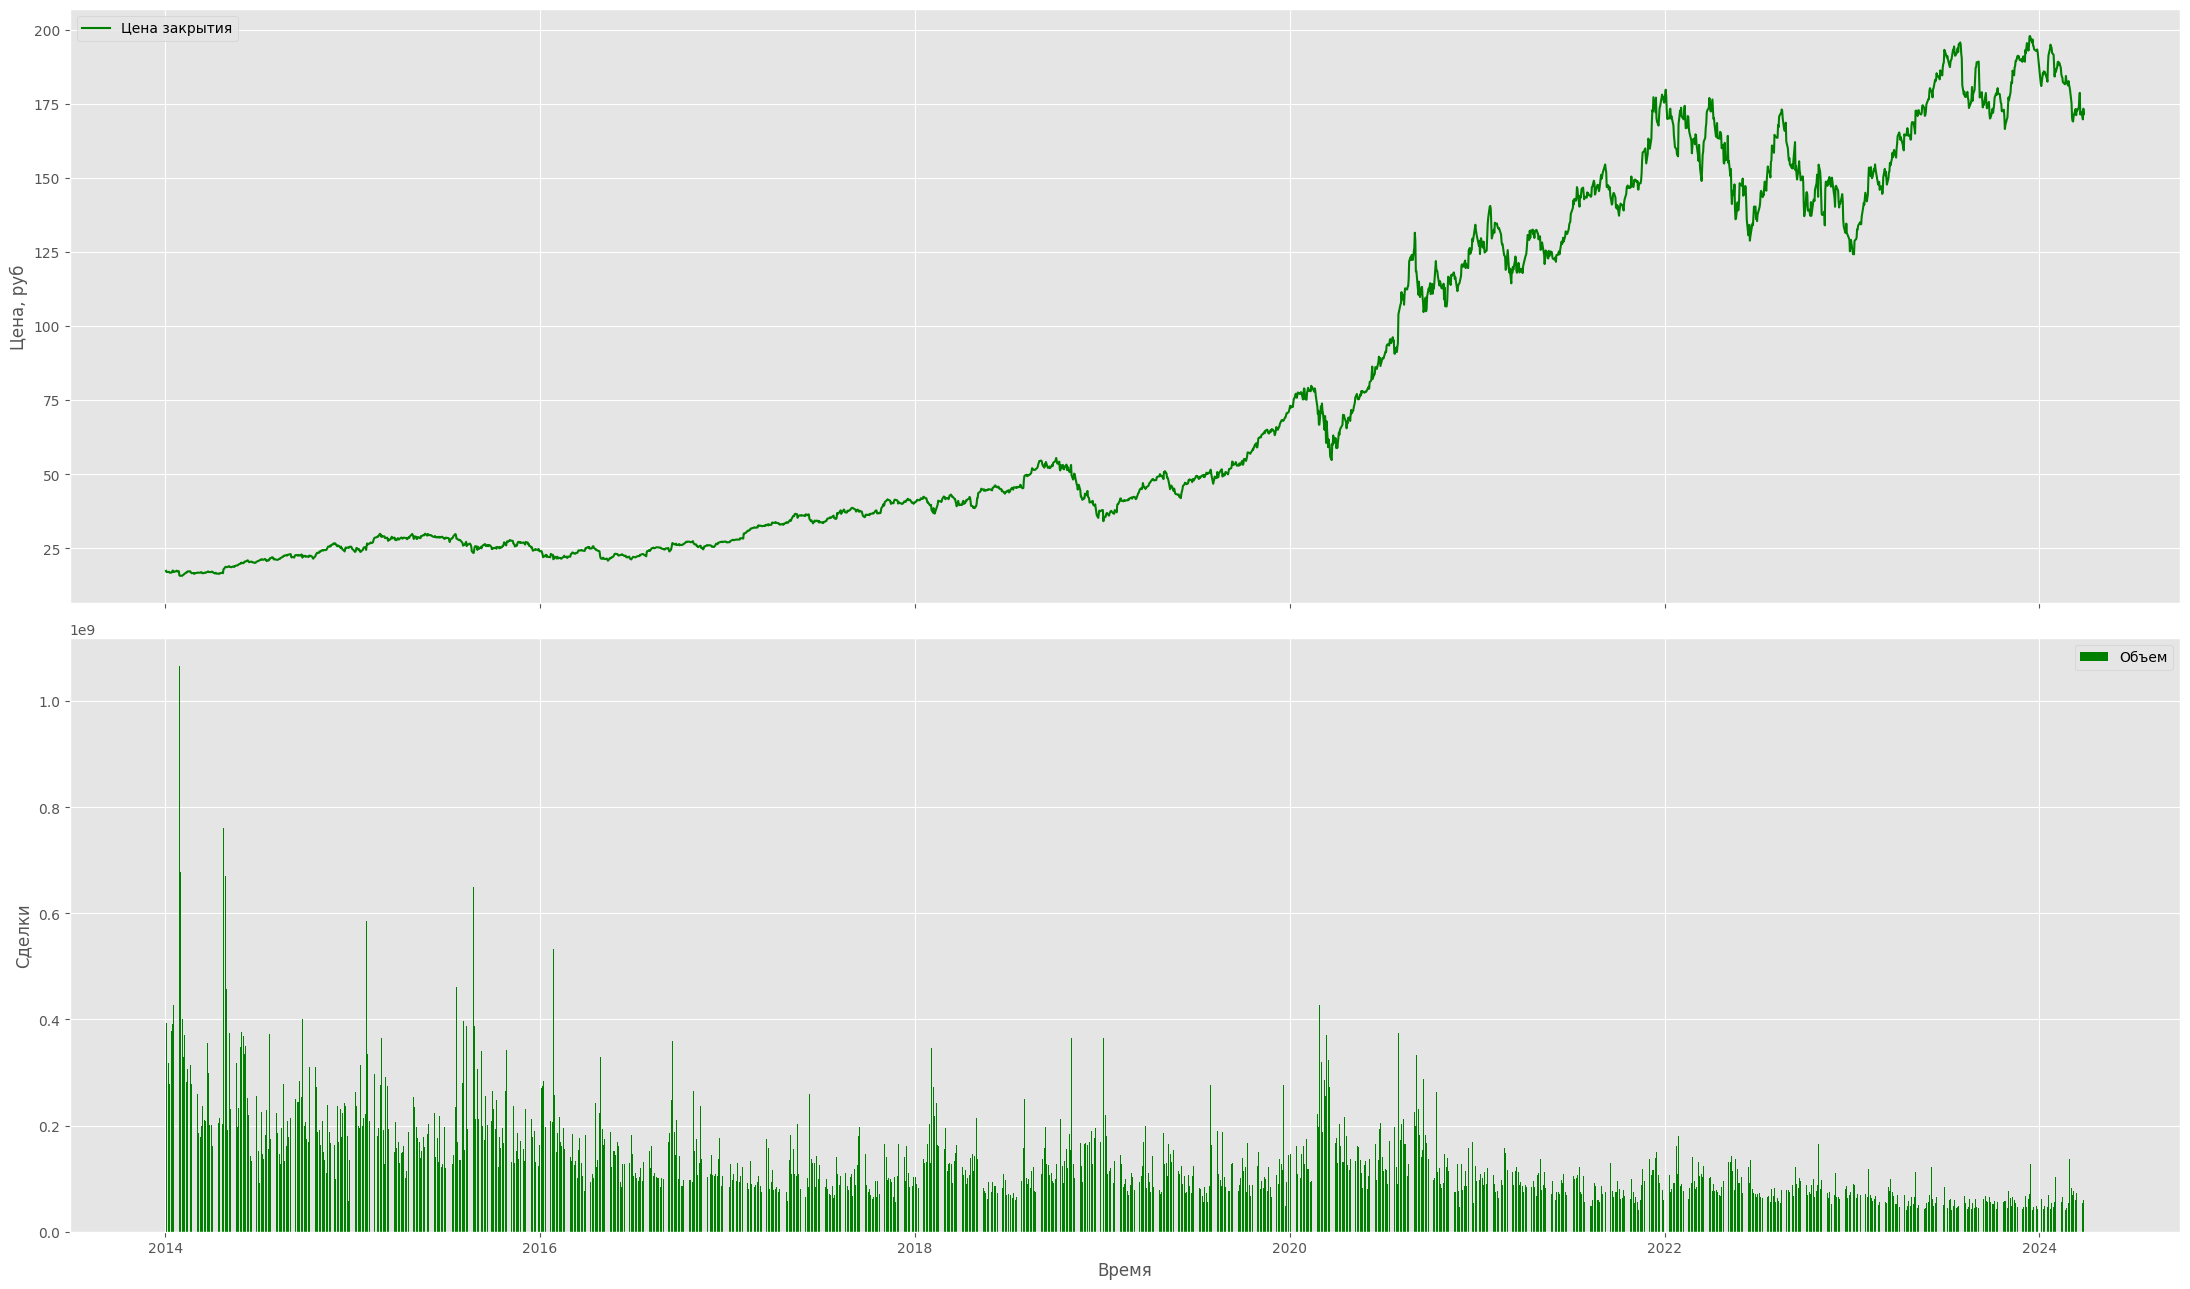

In [ ]:
# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 13), sharex=True)


# Отрисовка одного канала данных
# От начальной точки start длиной length
ax1.plot(price.index, price['Adj Close'], label='Цена закрытия', color='green')

ax1.set_ylabel('Цена, руб')
ax1.legend()

# Канал volume (объем)
ax2.bar(x=price.index,
        height=price['Volume'],
        label='Объем',
        color='green')
ax2.set_ylabel('Сделки')
ax2.legend()

plt.xlabel('Время')
# Регулировка пределов оси x
# plt.xlim(0, length)
# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()
# Фиксация графика
plt.show()

### Запуск генератора временных рядов

In [ ]:
#Пример генератора временных рядов
# Простая последовательность
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# параметры генератора
n_input = 3
batch_size = 1

generator = TimeseriesGenerator(series, series, length=n_input, batch_size=batch_size)

# Число сгенерированных примеров
print('Число примеров: %d' % len(generator))

# Вывод для каждого примера
for i in range(len(generator)):
    x, y = generator[i]

    print('%s => %s' % (x, y))

Число примеров: 7
[[1 2 3]] => [4]
[[2 3 4]] => [5]
[[3 4 5]] => [6]
[[4 5 6]] => [7]
[[5 6 7]] => [8]
[[6 7 8]] => [9]
[[7 8 9]] => [10]


### Избавление от тренда с помощью дифференцирования в датасете

In [ ]:
# Функция вычисления коэффициента автокорреляции

def get_corr_coef(
    data, # данные
    lag   # временной лаг
    ):

    array_data = np.asarray(data) # Преобразуем в массив NumPy

    # вычисление матрицы коэффициентов и отбор коэффициента из нужного места матрицы
    return np.corrcoef(array_data[lag:], array_data[:-lag])[0, 1]

In [ ]:
np.round(get_corr_coef(price['Adj Close'], 3), 2)

1.0

In [ ]:
np.round(get_corr_coef(np.diff(price['Adj Close']), 5), 2)

0.03

### Подготовка данных для генератора

In [ ]:
price.drop(columns=['Volume'], inplace=True)

train_data = price[:'2023-01-01']
test_data = price['2023-01-20':]


#Нормировка данных
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Проверка формы данных
print(f'Тренировочные данные: {scaled_train_data.shape}')
print(f'Тестовые данные: {scaled_test_data.shape}')

Тренировочные данные: (2266, 1)
Тестовые данные: (299, 1)


In [ ]:

n_input = 14  # Размерность входных данных
n_features = 1 # Размерность выходных данных
BATCH_SIZE = 2 # Размер пакета

#генерация обучающей выборки
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма обучающего пакета: {generator[0][0].shape}, y: {generator[0][1].shape}')

#генерация валидационной выборки
validator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма валидационного пакета: {validator[0][0].shape}, y: {validator[0][1].shape}')

#генерация тестовой выборки
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]
print(f'Форма тестовой выборки: {x_test.shape}, y: {y_test.shape}')

Форма обучающего пакета: (2, 14, 1), y: (2, 1)
Форма валидационного пакета: (2, 14, 1), y: (2, 1)
Форма тестовой выборки: (285, 14, 1), y: (285, 1)


### Создание вспомогательных функций

In [ ]:
# Объявление функции графика обучения
def history_plot(history, title):

    # Рисование графиков обучения
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

# Функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, dates=None, title=''):
    fig = plt.figure(figsize=(14, 7))
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    plt.plot(y_pred[1:], label=f'Прогноз')
    plt.plot(y_true[:-1], label=f'Базовый')
    plt.title(title)

    if dates is not None:
        plt.xticks(ticks=range(len(dates[1:])), labels=dates[1:], rotation=45)

    # Показываем только целые метки шкалы оси x
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.tight_layout()  # Чтобы метки не обрезались
    plt.show()

# Функция расчета результата предсказания
def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled



# Функция рисования корреляций прогнозного ряда и исходного со смещением
# break_step - ограничитель на число временных лагов

def show_corr(y_pred, y_true, title='', break_step=30):

    # выбираем наименьшее из длины y_len и break_step в качестве числа лагов для графика
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len+1, break_step+1]))

    # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]

    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

### Избавление от тренда с помощью дифференцирования в датасете

In [ ]:
# Модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 4, input_shape=generator[0][0].shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 4, activation='relu'))
model_conv.add(Conv1D(64, 4, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(50, activation='relu'))
model_conv.add(Dense(50, activation='relu'))
model_conv.add(Dense(n_features, activation='linear'))

model_conv.compile(optimizer='adam', loss='mse')

model_conv.fit(generator, validation_data=validator, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  23/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1477  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0112 - val_loss: 0.0011
Epoch 2/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 3/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 4/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0018 - val_loss: 7.8023e-04
Epoch 5/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0013 - val_loss: 7.8860e-04
Epoch 6/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 6.9579e-04
Epoch 7/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0012 - val_loss: 6.2406e-04
Epoch 8/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.2218e-04 - val_loss: 8.2405e-04
Epoch 9/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0012 - val_loss: 5.7636e-04
Epoch 10/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.8871e-04 - val_loss: 4.9960e-04
Epoch 11/20
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.1611e-04 - val_loss: 6.9146e-

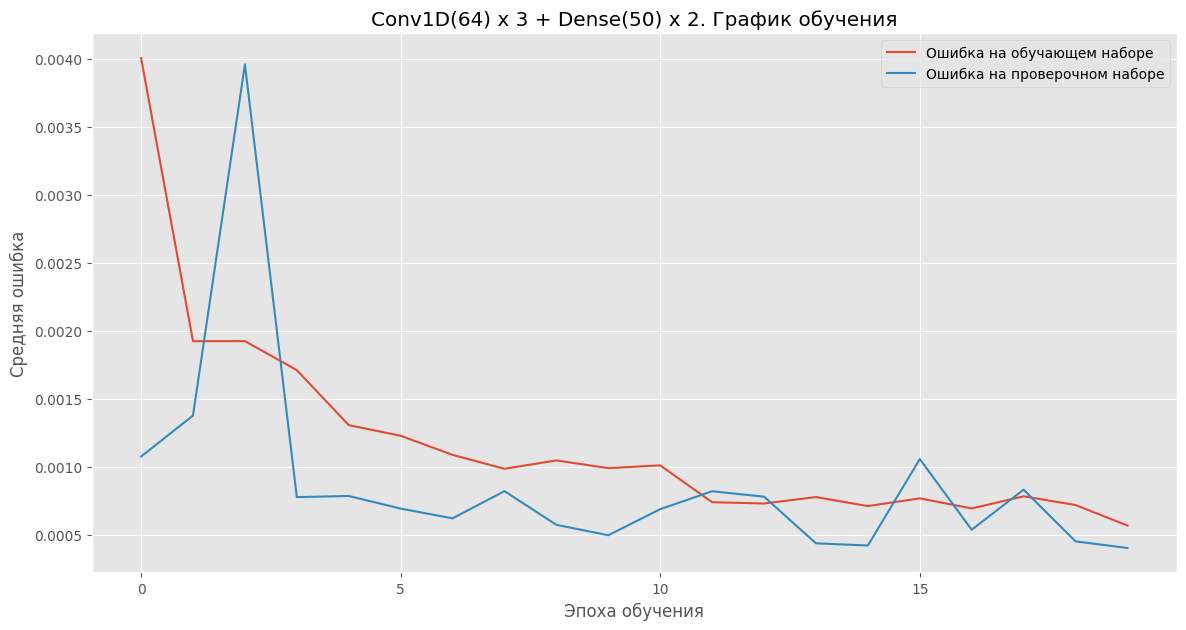

In [ ]:
history_plot(model_conv.history, 'Conv1D(64) х 3 + Dense(50) x 2')

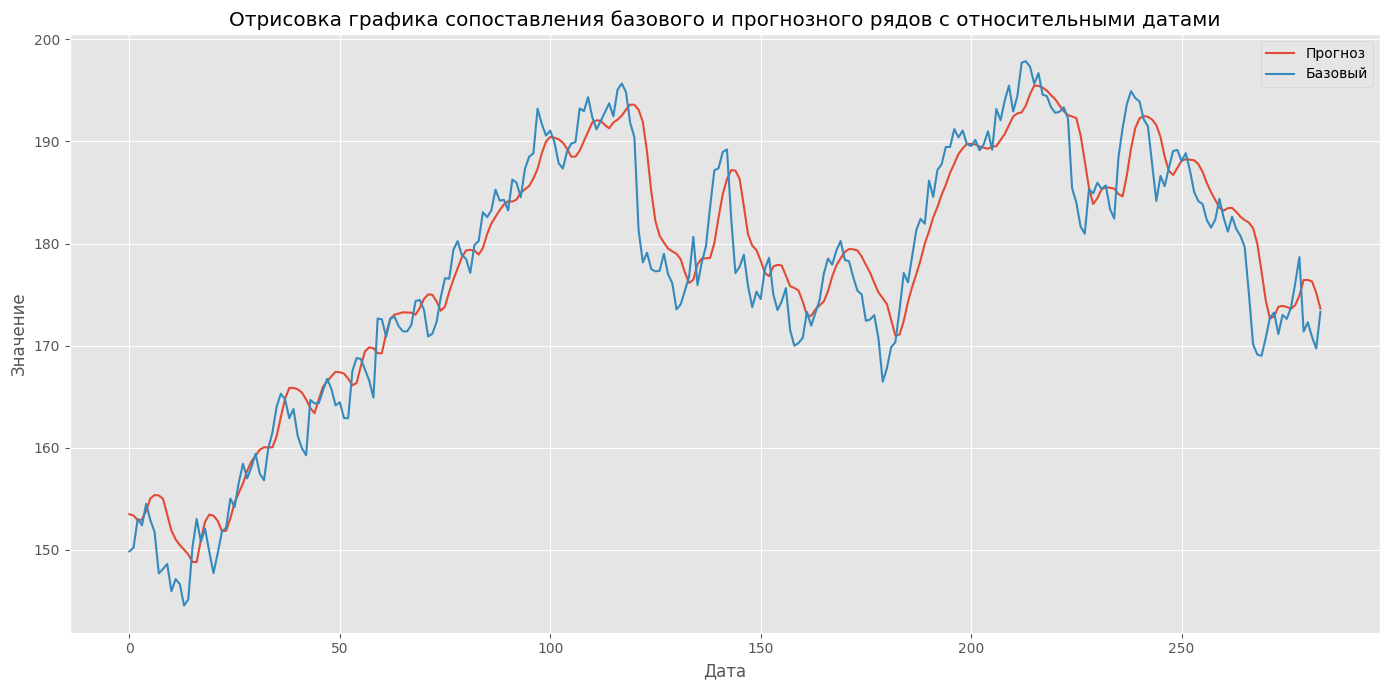

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_conv, x_test, y_test, scaler)
dates = test_data.index[-len(y_pred):].tolist()

# Отрисовка графика сопоставления базового и прогнозного рядов с реальными датами
show_predict(y_pred, y_true, title='Отрисовка графика сопоставления базового и прогнозного рядов с относительными датами')

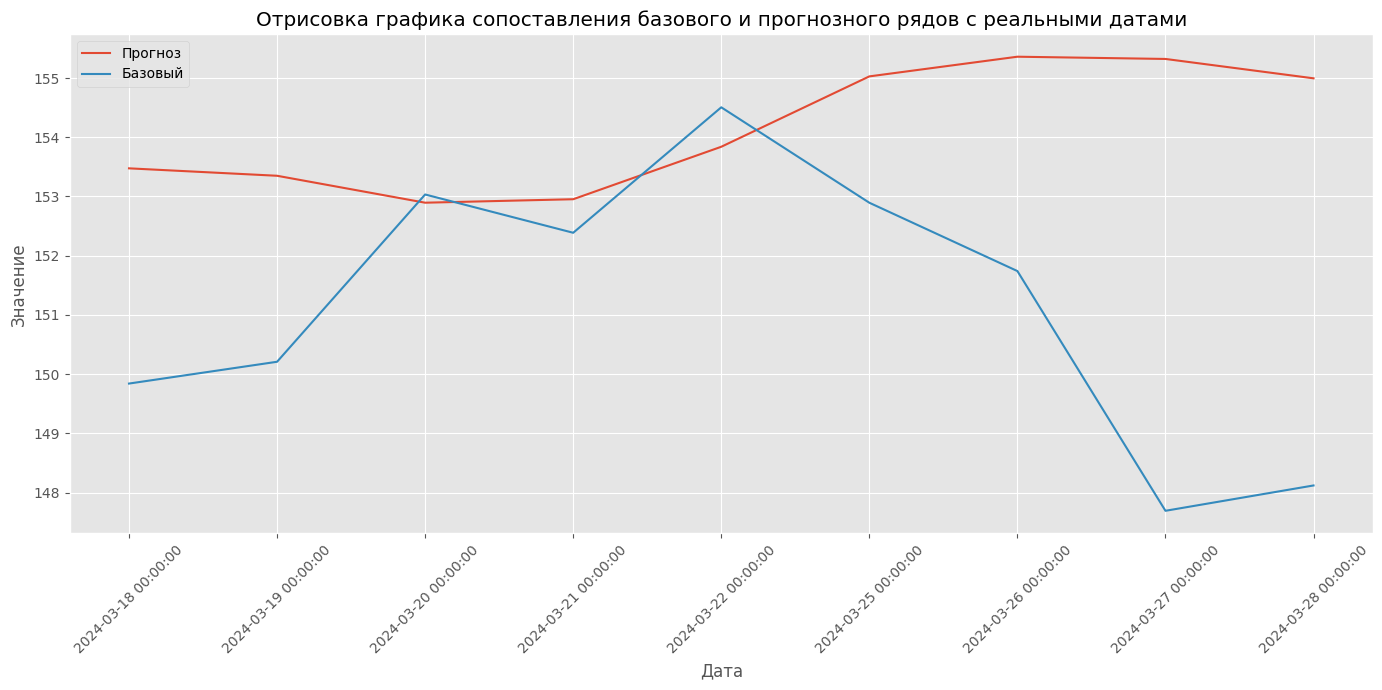

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_conv, x_test[:10], y_test[:10], scaler)
dates = test_data.index[-len(y_pred):].tolist()

# Отрисовка графика сопоставления базового и прогнозного рядов с реальными датами
show_predict(y_pred, y_true, dates, title='Отрисовка графика сопоставления базового и прогнозного рядов с реальными датами')

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


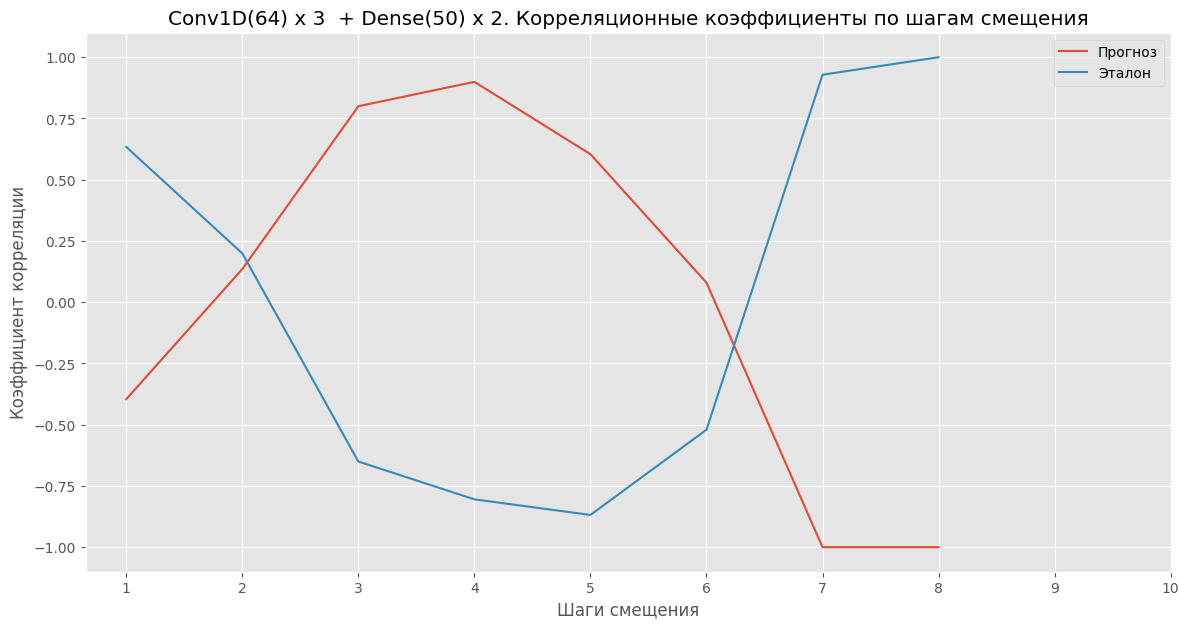

In [ ]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'Conv1D(64) х 3  + Dense(50) х 2. Корреляционные коэффициенты по шагам смещения')